In [47]:
import igibson.object_states as object_states
from igibson.tasks.behavior_task import BehaviorTask
from igibson.utils.ig_logging import IGLogReader
from igibson.utils.utils import parse_config
import os
import igibson
from igibson.envs.igibson_env import iGibsonEnv
from igibson.transition_model_v3.eval_env import EvalEnv
from igibson.transition_model_v3.eval_env import EvalActions
import igibson.object_states as object_states
from tqdm import tqdm
import json
import openai
import time
import matplotlib.pyplot as plt


demo_to_conds_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/all_conditions.json"
demo_to_objs_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/all_objects.json"
demo_names_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/100_selected_demos.txt"
task_to_instructions_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/instructions_by_activity_name.json"
prompt_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/prompts/behavior_goal_interpretation.txt"
task_to_demo_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/task_to_demo.json"
demo_to_prompt_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/llm_prompts.json"


with open(demo_to_conds_path, 'r') as json_file:
    demo_to_conds = json.load(json_file)

with open(demo_to_objs_path, 'r') as json_file:
    demo_to_objs = json.load(json_file)

with open(demo_to_prompt_path, 'r') as json_file:
    demo_to_prompt = json.load(json_file)

with open(task_to_instructions_path, 'r') as json_file:
    task_to_instructions = json.load(json_file)
    
with open(task_to_demo_path, 'r') as json_file:
    task_to_demos = json.load(json_file)

with open(demo_names_path, 'r') as file:
    demo_names = file.read().splitlines()

In [ ]:
for demo in demo_names:
    ground_truth_goal = 

In [48]:
gpt35_results_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/gpt35_goal_interpretation.json"
gpt4_results_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/gpt4_goal_interpretation.json"

with open(gpt35_results_path, 'r') as json_file:
    gpt35_results = json.load(json_file)

with open(gpt4_results_path, 'r') as json_file:
    gpt4_results = json.load(json_file)

In [56]:
prompts = []
for demo in demo_names:
    prompts.append(str(gpt4_results[demo]))

print(len(prompts))

100


In [57]:
from transformers import GPT2Tokenizer

def calculate_average_token_length(prompts):
    # Initialize the tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Tokenize each prompt and count the tokens
    token_counts = [len(tokenizer.encode(prompt)) for prompt in prompts]

    # Calculate the average token length
    average_tokens = sum(token_counts) / len(token_counts)
    return average_tokens

# Calculate the average token length
average_token_length = calculate_average_token_length(prompts)
print(f"The average token length is: {average_token_length}")


/Users/bryan/miniconda3/envs/main/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The average token length is: 167.92


In [ ]:
from transformers import GPT2Tokenizer

def calculate_average_token_length(prompts):
    # Initialize the tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Tokenize each prompt and count the tokens
    token_counts = [len(tokenizer.encode(prompt)) for prompt in prompts]

    # Calculate the average token length
    average_tokens = sum(token_counts) / len(token_counts)
    return average_tokens

# List of prompts
prompts = [
    "What is the future of artificial intelligence?",
    "Explain the theory of relativity.",
    "Describe the process of photosynthesis.",
    "How does quantum computing work?"
]

# Calculate the average token length
average_token_length = calculate_average_token_length(prompts)
print(f"The average token length is: {average_token_length}")


In [51]:
for key, value in demo_to_conds.items():
    demo_name = key
    goal_conds = value['goal_conditions']
    
    gpt4_pred = gpt4_results[demo_name]
    gpt35_pred = gpt35_results[demo_name]
    
    print("goal_conds: ", goal_conds)
    print("gpt4_pred: ", gpt4_pred)
    





goal_conds:  {'1': [[['not', ['stained', 'bathtub.n.01_1']]]]}
gpt4_pred:  {'node goals': [['not', ['Stained', 'bathtub.n.01_1']]], 'edge goals': []}


KeyError: 'putting_dishes_away_after_cleaning_0_Ihlen_1_int_0_2021-10-25_22-54-09'

In [5]:
import json
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def flatten_goals(goal_data):
    """Flatten goal data into a single list of conditions."""
    return [condition for goal_type in goal_data.values() for condition in goal_type]

def normalize_condition(condition):
    """Normalize conditions to ensure uniform comparison."""
    if isinstance(condition[1], list):
        return (condition[0].lower(),) + tuple(sorted(normalize_condition(subcond) for subcond in condition[1]))
    return tuple(map(str.lower, condition))

def evaluate_goals(predicted_goals, ground_truth_goals):
    """Evaluate predicted goals against ground truth goals."""
    # Flatten and normalize the predicted goals
    predicted_conditions = set(normalize_condition(cond) for cond in flatten_goals(predicted_goals))
    
    # Process ground truth to accommodate alternative satisfactions
    ground_truth_conditions = []
    for alternatives in ground_truth_goals.values():
        for option in alternatives:
            option_conditions = set(normalize_condition(cond) for cond in option)
            ground_truth_conditions.append(option_conditions)
    
    # Determine matches
    matches = defaultdict(bool)
    for i, option_conditions in enumerate(ground_truth_conditions):
        if option_conditions.issubset(predicted_conditions):
            matches[i] = True
    
    # Compute evaluation metrics
    true_positives = sum(matches.values())
    false_positives = len(predicted_conditions) - true_positives
    false_negatives = len(ground_truth_conditions) - true_positives
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate overall accuracy
    accuracy = true_positives / len(ground_truth_conditions) if ground_truth_conditions else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

# Example usage
predicted_goals_json = '{"node goals": [["not", ["Stained", "pan.n.01_1"]], ["not", ["Stained", "pan.n.01_2"]]], "edge goals": [["inside", "pan.n.01_1", "cabinet.n.01_1"]]}'
ground_truth_goals_json = '{"1": [[["not", ["stained", "pan.n.01_1"]], ["inside", "pan.n.01_1", "cabinet.n.01_1"]]], "2": [[["not", ["stained", "kettle.n.01_1"]], ["inside", "kettle.n.01_1", "cabinet.n.01_1"]]]}'

predicted_goals = json.loads(predicted_goals_json)
ground_truth_goals = json.loads(ground_truth_goals_json)

results = evaluate_goals(predicted_goals, ground_truth_goals)
print(results)


defaultdict(<class 'bool'>, {0: True})
{'accuracy': 0.5, 'precision': 0.3333333333333333, 'recall': 0.5, 'f1_score': 0.4}


In [25]:
import json
from collections import defaultdict

def flatten_goals(goal_data):
    """Flatten goal data into a single list of conditions."""
    return [condition for goal_type in goal_data.values() for condition in goal_type]

def evaluate_goals(predicted_goals, ground_truth_goals):
    """Evaluate predicted goals against ground truth goals."""
    # Flatten and normalize the predicted goals
    predicted_conditions = [cond for cond in flatten_goals(predicted_goals)]
    
    print("predicted_conditions", predicted_conditions)
    
    # Process ground truth to accommodate alternative satisfactions
    ground_truth_conditions = []
    all_conditions = []
    for alternatives in ground_truth_goals.values():
        for option in alternatives:
            option_conditions = [cond for cond in option]
            ground_truth_conditions.append(option_conditions)
            all_conditions.extend(option_conditions)

    # Determine matches
    matches = defaultdict(bool)
    matched_conditions = []
    for option_conditions in ground_truth_conditions:
        if option_conditions.issubset(predicted_conditions):
            matches[tuple(option_conditions)] = True
            matched_conditions.extend(option_conditions)
    
    unmatched_conditions = all_conditions - matched_conditions

    # Compute evaluation metrics
    true_positives = len(matched_conditions)
    false_positives = len(predicted_conditions - matched_conditions)
    false_negatives = len(unmatched_conditions)
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': true_positives / len(all_conditions) if all_conditions else 0,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'matched_conditions': list(map(list, matched_conditions)),
        'unmatched_conditions': list(map(list, unmatched_conditions))
    }

In [3]:
import json

def flatten_goals(goal_data):
    """Flatten goal data into a single list of conditions."""
    return [condition for goal_type in goal_data.values() for condition in goal_type]

def check_satisfaction(predicted_conditions, ground_truth_conditions):
    satisfied_conditions = []
    unsatisfied_conditions = []
    for condition in ground_truth_conditions:
        if condition in predicted_conditions:
            satisfied_conditions.append(condition)
        else:
            unsatisfied_conditions.append(condition)
    return satisfied_conditions, unsatisfied_conditions


def evaluate_goals(predicted_goals, ground_truth_goals):
    """Evaluate predicted goals against ground truth goals."""
    # Flatten the predicted goals
    predicted_conditions = flatten_goals(predicted_goals)
    
    
    all_satisfied_conditions = []
    all_unsatisfied_conditions = []
    
    # check each goal in ground_truth_goals
    for key, value in ground_truth_goals.items():
        if len(value) == 1:
            satisfied_conditions, unsatisfied_conditions = check_satisfaction(predicted_conditions, value[0])
        # if there are multiple ways to satisfy the goal, choose the one that satisfies the most number of conditions
        else:
            satisfied_nums = [len([cond for cond in option if cond in predicted_conditions]) for option in value]
            max_satisfied_option = value[satisfied_nums.index(max(satisfied_nums))]
            satisfied_conditions, unsatisfied_conditions = check_satisfaction(predicted_conditions, max_satisfied_option)
        
        all_satisfied_conditions.extend(satisfied_conditions)
        all_unsatisfied_conditions.extend(unsatisfied_conditions)                         
            
    # Compute evaluation metrics
    true_positives = len(all_satisfied_conditions)
    false_positives = len(predicted_conditions) - true_positives
    false_negatives = len(all_unsatisfied_conditions)
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': true_positives / (true_positives + false_positives + false_negatives),
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'all_satisfied_conditions': all_satisfied_conditions,
        'all_unsatisfied_conditions': all_unsatisfied_conditions,
        'predicted_conditions': predicted_conditions
    }
    


In [42]:
demo = "assembling_gift_baskets_0_Beechwood_0_int_0_2021-10-26_12-46-37"
# demo = "bottling_fruit_0_Wainscott_0_int_0_2021-05-24_19-46-46"

prompt = demo_to_prompt[demo]

gpt4_pred = gpt4_results[demo]
gpt35_pred = gpt35_results[demo]

goal_conds = demo_to_conds[demo]['goal_conditions']
# goal_conds
gpt35_pred
# print(prompt)



# goal_conds = demo_to_conds[demo]['goal_conditions']
# gpt4_pred = gpt4_results[demo]

# print("goal_conds: ", goal_conds)
# print("gpt4_pred: ", gpt4_pred)

# results = evaluate_goals(gpt4_pred, goal_conds)
# results

{'node goals': [['inside', 'candle.n.01_1'],
  ['inside', 'cheese.n.01_1'],
  ['inside', 'cookie.n.01_1'],
  ['inside', 'bow.n.08_1']],
 'edge goals': []}

In [45]:
string = """
GPT3.5 Prediction (assembling_gift_baskets):
{'node goals': 
[['inside', 'candle.n.01_1'],
  ['inside', 'cheese.n.01_1'],
  ['inside', 'cookie.n.01_1'],
  ['inside', 'bow.n.08_1']],
 'edge goals': []}
"""
print(string)


GPT3.5 Prediction (assembling_gift_baskets):
{'node goals': 
[['inside', 'candle.n.01_1'],
  ['inside', 'cheese.n.01_1'],
  ['inside', 'cookie.n.01_1'],
  ['inside', 'bow.n.08_1']],
 'edge goals': []}



In [44]:
string = """
Flattened Goal Condition Options: 
{'1': [[['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_2'],
   ['inside', 'candle.n.01_3', 'basket.n.01_3'],
   ['inside', 'candle.n.01_4', 'basket.n.01_4']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_2'],
   ['inside', 'candle.n.01_3', 'basket.n.01_4'],
   ['inside', 'candle.n.01_4', 'basket.n.01_3']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_3'],
   ['inside', 'candle.n.01_3', 'basket.n.01_2'],
   ['inside', 'candle.n.01_4', 'basket.n.01_4']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_3'],
   ['inside', 'candle.n.01_3', 'basket.n.01_4'],
   ['inside', 'candle.n.01_4', 'basket.n.01_2']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_4'],
   ['inside', 'candle.n.01_3', 'basket.n.01_2'],
   ['inside', 'candle.n.01_4', 'basket.n.01_3']],
...
   ['inside', 'bow.n.08_4', 'basket.n.01_4']],
  [['inside', 'bow.n.08_1', 'basket.n.01_2'],
   ['inside', 'bow.n.08_2', 'basket.n.01_3'],
   ['inside', 'bow.n.08_3', 'basket.n.01_4'],
   ['inside', 'bow.n.08_4', 'basket.n.01_1']]]
"""


string = """
'4': [[['inside', 'bow.n.08_1', 'basket.n.01_1'],
   ['inside', 'bow.n.08_2', 'basket.n.01_2'],
   ['inside', 'bow.n.08_3', 'basket.n.01_3'],
   ['inside', 'bow.n.08_4', 'basket.n.01_4']],
  [['inside', 'bow.n.08_1', 'basket.n.01_1'],
   ['inside', 'bow.n.08_2', 'basket.n.01_2'],
   ['inside', 'bow.n.08_3', 'basket.n.01_4'],
   ['inside', 'bow.n.08_4', 'basket.n.01_3']],
  [['inside', 'bow.n.08_1', 'basket.n.01_1'],
   ['inside', 'bow.n.08_2', 'basket.n.01_3'],
   ['inside', 'bow.n.08_3', 'basket.n.01_2'],
   ['inside', 'bow.n.08_4', 'basket.n.01_4']],
  [['inside', 'bow.n.08_1', 'basket.n.01_1'],
   ['inside', 'bow.n.08_2', 'basket.n.01_3'],
   ['inside', 'bow.n.08_3', 'basket.n.01_4'],
   ['inside', 'bow.n.08_4', 'basket.n.01_2']],
  [['inside', 'bow.n.08_1', 'basket.n.01_1'],
   ['inside', 'bow.n.08_2', 'basket.n.01_4'],
   ['inside', 'bow.n.08_3', 'basket.n.01_2'],
   ['inside', 'bow.n.08_4', 'basket.n.01_3']],
  [['inside', 'bow.n.08_1', 'basket.n.01_1'],
   ['inside', 'bow.n.08_2', 'basket.n.01_4'],
   ['inside', 'bow.n.08_3', 'basket.n.01_3'],
   ['inside', 'bow.n.08_4', 'basket.n.01_2']],
  [['inside', 'bow.n.08_1', 'basket.n.01_2'],
   ['inside', 'bow.n.08_2', 'basket.n.01_1'],
   ['inside', 'bow.n.08_3', 'basket.n.01_3'],
   ['inside', 'bow.n.08_4', 'basket.n.01_4']]}
"""


string = """
Flattened Goal Condition Options:  
{'1': [[['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_2'],
   ['inside', 'candle.n.01_3', 'basket.n.01_3'],
   ['inside', 'candle.n.01_4', 'basket.n.01_4']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_2'],
   ['inside', 'candle.n.01_3', 'basket.n.01_4'],
   ['inside', 'candle.n.01_4', 'basket.n.01_3']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_3'],
   ['inside', 'candle.n.01_3', 'basket.n.01_2'],
   ['inside', 'candle.n.01_4', 'basket.n.01_4']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_3'],
   ['inside', 'candle.n.01_3', 'basket.n.01_4'],
   ['inside', 'candle.n.01_4', 'basket.n.01_2']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_4'],
   ['inside', 'candle.n.01_3', 'basket.n.01_2'],
   ['inside', 'candle.n.01_4', 'basket.n.01_3']],
...
   ['inside', 'bow.n.08_4', 'basket.n.01_4']],
  [['inside', 'bow.n.08_1', 'basket.n.01_2'],
   ['inside', 'bow.n.08_2', 'basket.n.01_3'],
   ['inside', 'bow.n.08_3', 'basket.n.01_4'],
   ['inside', 'bow.n.08_4', 'basket.n.01_1']]]
"""
print(string)


Flattened Goal Condition Options:  
{'1': [[['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_2'],
   ['inside', 'candle.n.01_3', 'basket.n.01_3'],
   ['inside', 'candle.n.01_4', 'basket.n.01_4']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_2'],
   ['inside', 'candle.n.01_3', 'basket.n.01_4'],
   ['inside', 'candle.n.01_4', 'basket.n.01_3']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_3'],
   ['inside', 'candle.n.01_3', 'basket.n.01_2'],
   ['inside', 'candle.n.01_4', 'basket.n.01_4']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_3'],
   ['inside', 'candle.n.01_3', 'basket.n.01_4'],
   ['inside', 'candle.n.01_4', 'basket.n.01_2']],
  [['inside', 'candle.n.01_1', 'basket.n.01_1'],
   ['inside', 'candle.n.01_2', 'basket.n.01_4'],
   ['inside', 'candle.n.01_3', 'basket.n.01_2'],
   ['inside', 'candle.n

In [46]:
string = """
Flattened Ground Truth Goal Conditions:{
    '1': [[['inside', 'strawberry.n.01_1', 'jar.n.01_1'], ['not', ['inside', 'peach.n.03_1', 'jar.n.01_1']]],
        [['inside', 'strawberry.n.01_1', 'jar.n.01_2'], ['not', ['inside', 'peach.n.03_1', 'jar.n.01_2']]]],
    '2': [[['inside', 'peach.n.03_1', 'jar.n.01_1'], ['not', ['inside', 'strawberry.n.01_1', 'jar.n.01_1']]],
        [['inside', 'peach.n.03_1', 'jar.n.01_2'], ['not', ['inside', 'strawberry.n.01_1', 'jar.n.01_2']]]],
    '3': [[['not', ['open', 'jar.n.01_1']], ['not', ['open', 'jar.n.01_2']]]],
    '4': [[['sliced', 'strawberry.n.01_1']]],
    '5': [[['sliced', 'peach.n.03_1']]]
}
"""

# string = """
# GPT4 Predicted Goal Conditions:{
# 'node goals':   [['Sliced', 'strawberry.n.01_1'],
#                 ['Sliced', 'peach.n.03_1'],
#                 ['Open', 'jar.n.01_1'],
#                 ['Open', 'jar.n.01_2']],
# 'edge goals':   [['inside', 'strawberry.n.01_1', 'jar.n.01_1'],
#                 ['inside', 'peach.n.03_1', 'jar.n.01_2'],
#                 ['not', ['Open', 'jar.n.01_1']],
#                 ['not', ['Open', 'jar.n.01_2']]]
# }
# """

string = """
BDDL Goal Conditions: 
['forpairs', 'basket.n.01-basket.n.01', 'candle.n.01-candle.n.01', 'inside', 'candle.n.01', 'basket.n.01']
['forpairs', 'basket.n.01-basket.n.01', 'cheese.n.01-cheese.n.01', 'inside', 'cheese.n.01', 'basket.n.01']
['forpairs', 'basket.n.01-basket.n.01', 'cookie.n.01-cookie.n.01', 'inside', 'cookie.n.01', 'basket.n.01']
['forpairs', 'basket.n.01-basket.n.01', 'bow.n.08-bow.n.08', 'inside', 'bow.n.08', 'basket.n.01']
"""

print(string)


BDDL Goal Conditions: 
['forpairs', 'basket.n.01-basket.n.01', 'candle.n.01-candle.n.01', 'inside', 'candle.n.01', 'basket.n.01']
['forpairs', 'basket.n.01-basket.n.01', 'cheese.n.01-cheese.n.01', 'inside', 'cheese.n.01', 'basket.n.01']
['forpairs', 'basket.n.01-basket.n.01', 'cookie.n.01-cookie.n.01', 'inside', 'cookie.n.01', 'basket.n.01']
['forpairs', 'basket.n.01-basket.n.01', 'bow.n.08-bow.n.08', 'inside', 'bow.n.08', 'basket.n.01']



In [25]:
# check that all options of the same condition set has the same number of conditions to satisfy

for key, value in demo_to_conds.items():
    demo_name = key
    goal_conds = value['goal_conditions']
    
    for key, value in goal_conds.items():
        if len(value) != 1:
            length = len(value[0])
            for option in value:
                if len(option) != length:
                    print(demo_name)
                    print(option)
                    print("\n")

In [9]:
all_satisfied_conditions = []
all_unsatisfied_conditions = []
all_predicted_conditions = []
all_ground_truth_conditions = []

gpt4_results_evaluated = {}


for demo in demo_names:
    goal_conds = demo_to_conds[demo]['goal_conditions']
    gpt4_pred = gpt4_results[demo]
    results = evaluate_goals(gpt4_pred, goal_conds)
    
    all_satisfied_conditions.extend(results['all_satisfied_conditions'])
    all_unsatisfied_conditions.extend(results['all_unsatisfied_conditions'])
    all_ground_truth_conditions.extend(results['all_unsatisfied_conditions'])
    all_ground_truth_conditions.extend(results['all_satisfied_conditions'])
    all_predicted_conditions.extend(flatten_goals(gpt4_pred))
    gpt4_results_evaluated[demo] = results

save_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/gpt4_goal_interpretation_evaluated.json"
with open(save_path, 'w') as json_file:
    json.dump(gpt4_results_evaluated, json_file, indent=4)
    

print("all_satisfied_conditions: ", len(all_satisfied_conditions))
print("all_unsatisfied_conditions: ", len(all_unsatisfied_conditions))
print("all_predicted_conditions: ", len(all_predicted_conditions))
print("all_ground_truth_conditions: ", len(all_ground_truth_conditions))
 # Compute evaluation metrics
true_positives = len(all_satisfied_conditions)
false_positives = len(all_predicted_conditions) - true_positives
false_negatives = len(all_unsatisfied_conditions)
precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

result = {
        'accuracy': true_positives / (true_positives + false_positives + false_negatives),
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'all_satisfied_conditions': all_satisfied_conditions,
        'all_unsatisfied_conditions': all_unsatisfied_conditions
    }
result

all_satisfied_conditions:  516
all_unsatisfied_conditions:  157
all_predicted_conditions:  688
all_ground_truth_conditions:  673


{'accuracy': 0.6106508875739645,
 'precision': 0.75,
 'recall': 0.7667161961367014,
 'f1_score': 0.7582659808963998,
 'true_positives': 516,
 'false_positives': 172,
 'false_negatives': 157,
 'all_satisfied_conditions': [['not', ['stained', 'bathtub.n.01_1']],
  ['inside', 'plate.n.04_1', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_2', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_3', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_4', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_5', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_6', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_7', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_8', 'cabinet.n.01_1'],
  ['not', ['stained', 'pan.n.01_1']],
  ['inside', 'pan.n.01_1', 'cabinet.n.01_1'],
  ['not', ['stained', 'pan.n.01_2']],
  ['not', ['stained', 'pan.n.01_3']],
  ['not', ['stained', 'kettle.n.01_1']],
  ['inside', 'kettle.n.01_1', 'cabinet.n.01_2'],
  ['not', ['stained', 'teapot.n.01_1']],
  ['inside', 'teapot.n.01_1', 'cabinet.n.01_1'],
  ['not', ['dus

In [8]:
all_satisfied_conditions = []
all_unsatisfied_conditions = []
all_predicted_conditions = []
all_ground_truth_conditions = []

gpt35_results_evaluated = {}


for demo in demo_names:
    goal_conds = demo_to_conds[demo]['goal_conditions']
    gpt35_pred = gpt35_results[demo]
    results = evaluate_goals(gpt35_pred, goal_conds)
    
    all_satisfied_conditions.extend(results['all_satisfied_conditions'])
    all_unsatisfied_conditions.extend(results['all_unsatisfied_conditions'])
    all_ground_truth_conditions.extend(results['all_unsatisfied_conditions'])
    all_ground_truth_conditions.extend(results['all_satisfied_conditions'])
    all_predicted_conditions.extend(flatten_goals(gpt35_pred))
    gpt35_results_evaluated[demo] = results

save_path = "/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/assets/gpt4_goal_interpretation_evaluated.json"
with open(save_path, 'w') as json_file:
    json.dump(gpt35_results_evaluated, json_file, indent=4)


print("all_satisfied_conditions: ", len(all_satisfied_conditions))
print("all_unsatisfied_conditions: ", len(all_unsatisfied_conditions))
print("all_predicted_conditions: ", len(all_predicted_conditions))
print("all_ground_truth_conditions: ", len(all_ground_truth_conditions))
 # Compute evaluation metrics
true_positives = len(all_satisfied_conditions)
false_positives = len(all_predicted_conditions) - true_positives
false_negatives = len(all_unsatisfied_conditions)
precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

result = {
        'accuracy': true_positives / (true_positives + false_positives + false_negatives),
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'all_satisfied_conditions': all_satisfied_conditions,
        'all_unsatisfied_conditions': all_unsatisfied_conditions
    }
result

all_satisfied_conditions:  409
all_unsatisfied_conditions:  264
all_predicted_conditions:  674
all_ground_truth_conditions:  673


{'accuracy': 0.43603411513859275,
 'precision': 0.6068249258160238,
 'recall': 0.6077265973254086,
 'f1_score': 0.6072754268745361,
 'true_positives': 409,
 'false_positives': 265,
 'false_negatives': 264,
 'all_satisfied_conditions': [['not', ['stained', 'bathtub.n.01_1']],
  ['inside', 'plate.n.04_1', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_2', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_3', 'cabinet.n.01_1'],
  ['inside', 'plate.n.04_4', 'cabinet.n.01_1'],
  ['not', ['stained', 'pan.n.01_1']],
  ['not', ['stained', 'pan.n.01_2']],
  ['not', ['stained', 'pan.n.01_3']],
  ['not', ['stained', 'kettle.n.01_1']],
  ['not', ['stained', 'teapot.n.01_1']],
  ['not', ['dusty', 'table.n.02_1']],
  ['not', ['dusty', 'shelf.n.01_1']],
  ['not', ['dusty', 'gym_shoe.n.01_1']],
  ['not', ['dusty', 'gym_shoe.n.01_2']],
  ['not', ['dusty', 'gym_shoe.n.01_3']],
  ['not', ['dusty', 'gym_shoe.n.01_4']],
  ['not', ['stained', 'gym_shoe.n.01_1']],
  ['not', ['stained', 'gym_shoe.n.01_2']],
  ['not', 

In [6]:
f1_scores = {}
precisions = {}
recall = {}
accuracy = {}

for task_name, demo_name in task_to_demos.items():
    goal_conds = demo_to_conds[demo_name]['goal_conditions']
    # gpt35_pred = gpt35_results[demo_name]
    # gpt35_results = evaluate_goals(gpt35_pred, goal_conds)
    gpt4_pred = gpt4_results[demo_name]
    gpt4_result = evaluate_goals(gpt4_pred, goal_conds)
    f1_scores[task_name] = gpt4_result['f1_score']
    precisions[task_name] = gpt4_result['precision']
    recall[task_name] = gpt4_result['recall']
    accuracy[task_name] = gpt4_result['accuracy']


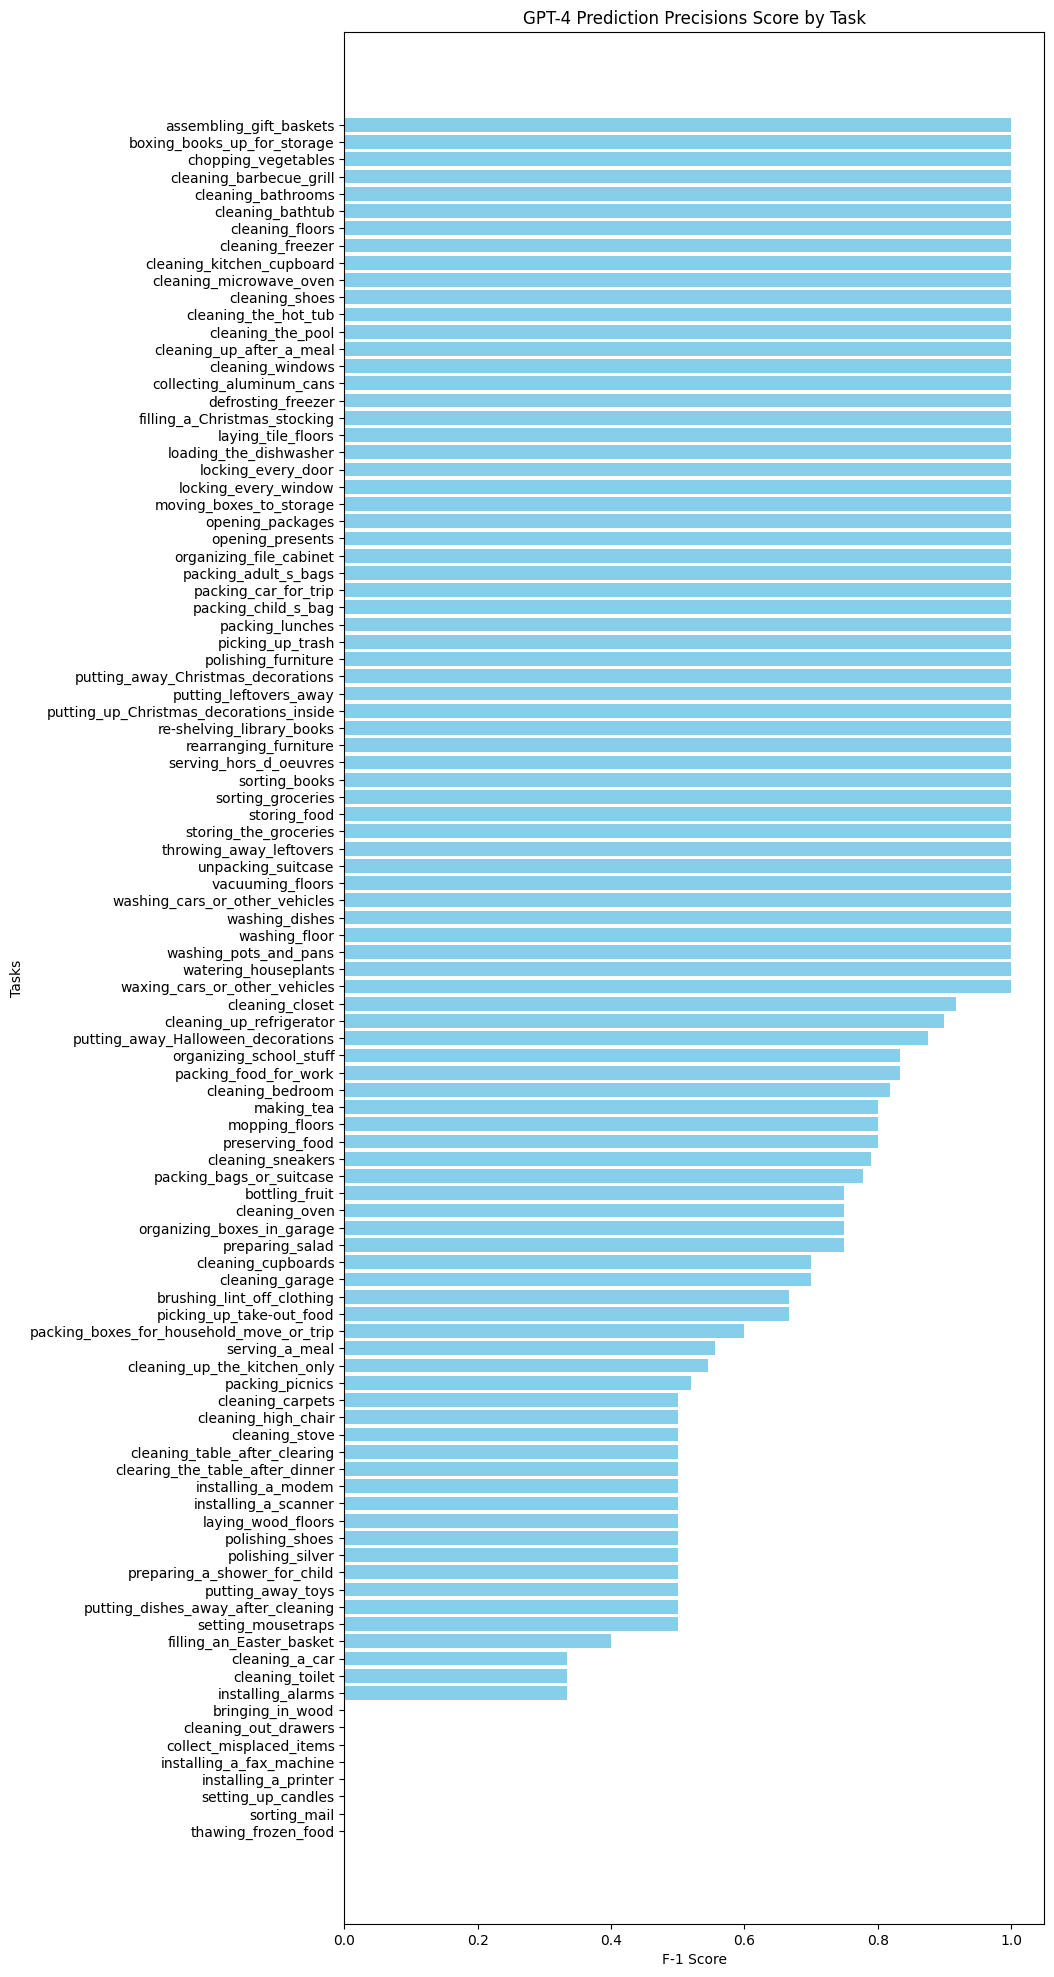

In [29]:
# Sort the tasks first by descending F-1 score, then alphabetically by task name
sorted_tasks = sorted(precisions.items(), key=lambda x: (-x[1], x[0]))

# Unpack the sorted items for plotting
tasks, scores = zip(*sorted_tasks)

# Creating the horizontal bar graph
plt.figure(figsize=(10, 15))  # Adjusted for a vertical layout
plt.barh(tasks, scores, color='skyblue')
plt.xlabel('F-1 Score')
plt.ylabel('Tasks')
plt.title('GPT-4 Prediction Precisions Score by Task')
plt.gca().invert_yaxis()  # Inverts the y-axis so high scores are at the top
plt.tight_layout()  # Adjusts subplots to give some padding
plt.subplots_adjust(left=0.2, right=0.9, top=1.3)  # Adjust the margins

# Save the plot to a file
plt.savefig('/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/images/GPT4_Precision_Scores.png', format='png', dpi=400, bbox_inches='tight')  # Saves the plot as a PNG file with high resolution

plt.show()



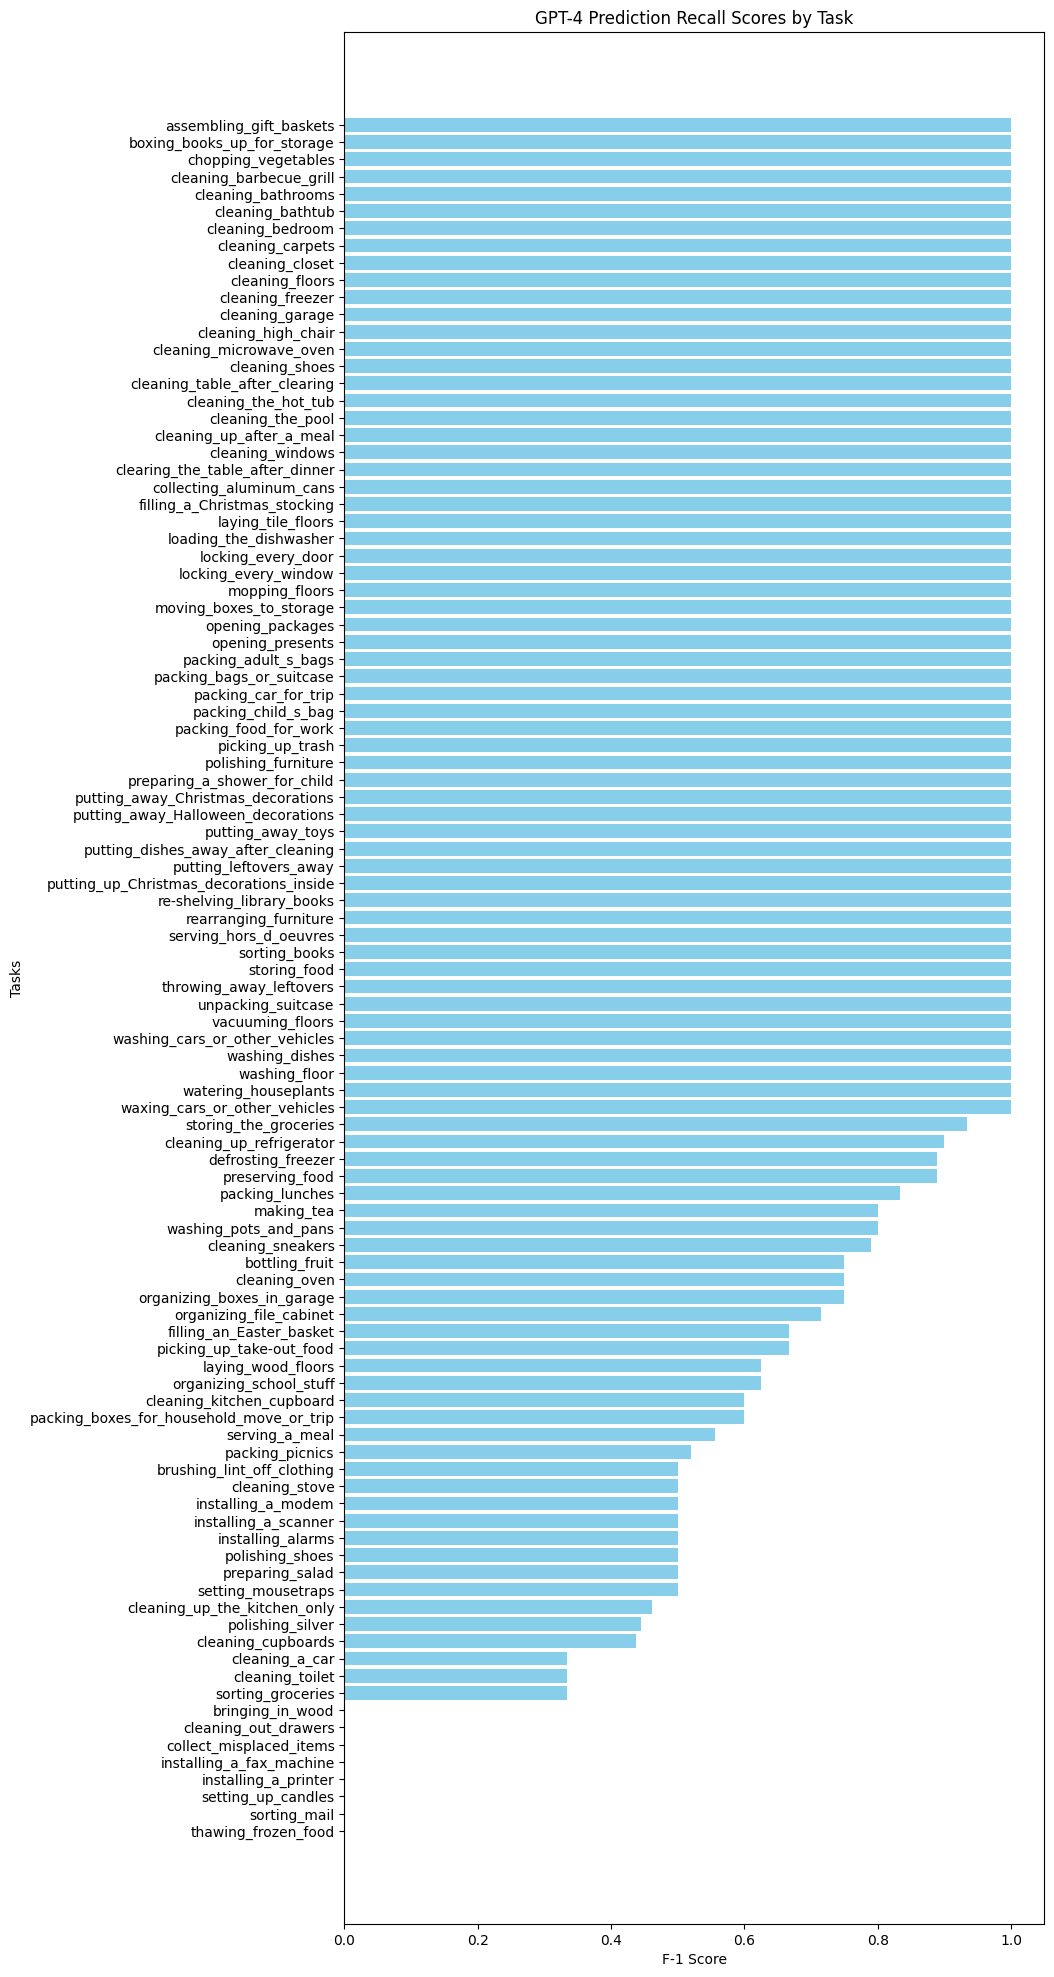

In [27]:
# Sort the tasks first by descending F-1 score, then alphabetically by task name
sorted_tasks = sorted(recall.items(), key=lambda x: (-x[1], x[0]))

# Unpack the sorted items for plotting
tasks, scores = zip(*sorted_tasks)

# Creating the horizontal bar graph
plt.figure(figsize=(10, 15))  # Adjusted for a vertical layout
plt.barh(tasks, scores, color='skyblue')
plt.xlabel('F-1 Score')
plt.ylabel('Tasks')
plt.title('GPT-4 Prediction Recall Scores by Task')
plt.gca().invert_yaxis()  # Inverts the y-axis so high scores are at the top
plt.tight_layout()  # Adjusts subplots to give some padding
plt.subplots_adjust(left=0.2, right=0.9, top=1.3)  # Adjust the margins

# Save the plot to a file
plt.savefig('/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/images/GPT4_Recall_Scores.png', format='png', dpi=400, bbox_inches='tight')  # Saves the plot as a PNG file with high resolution

plt.show()


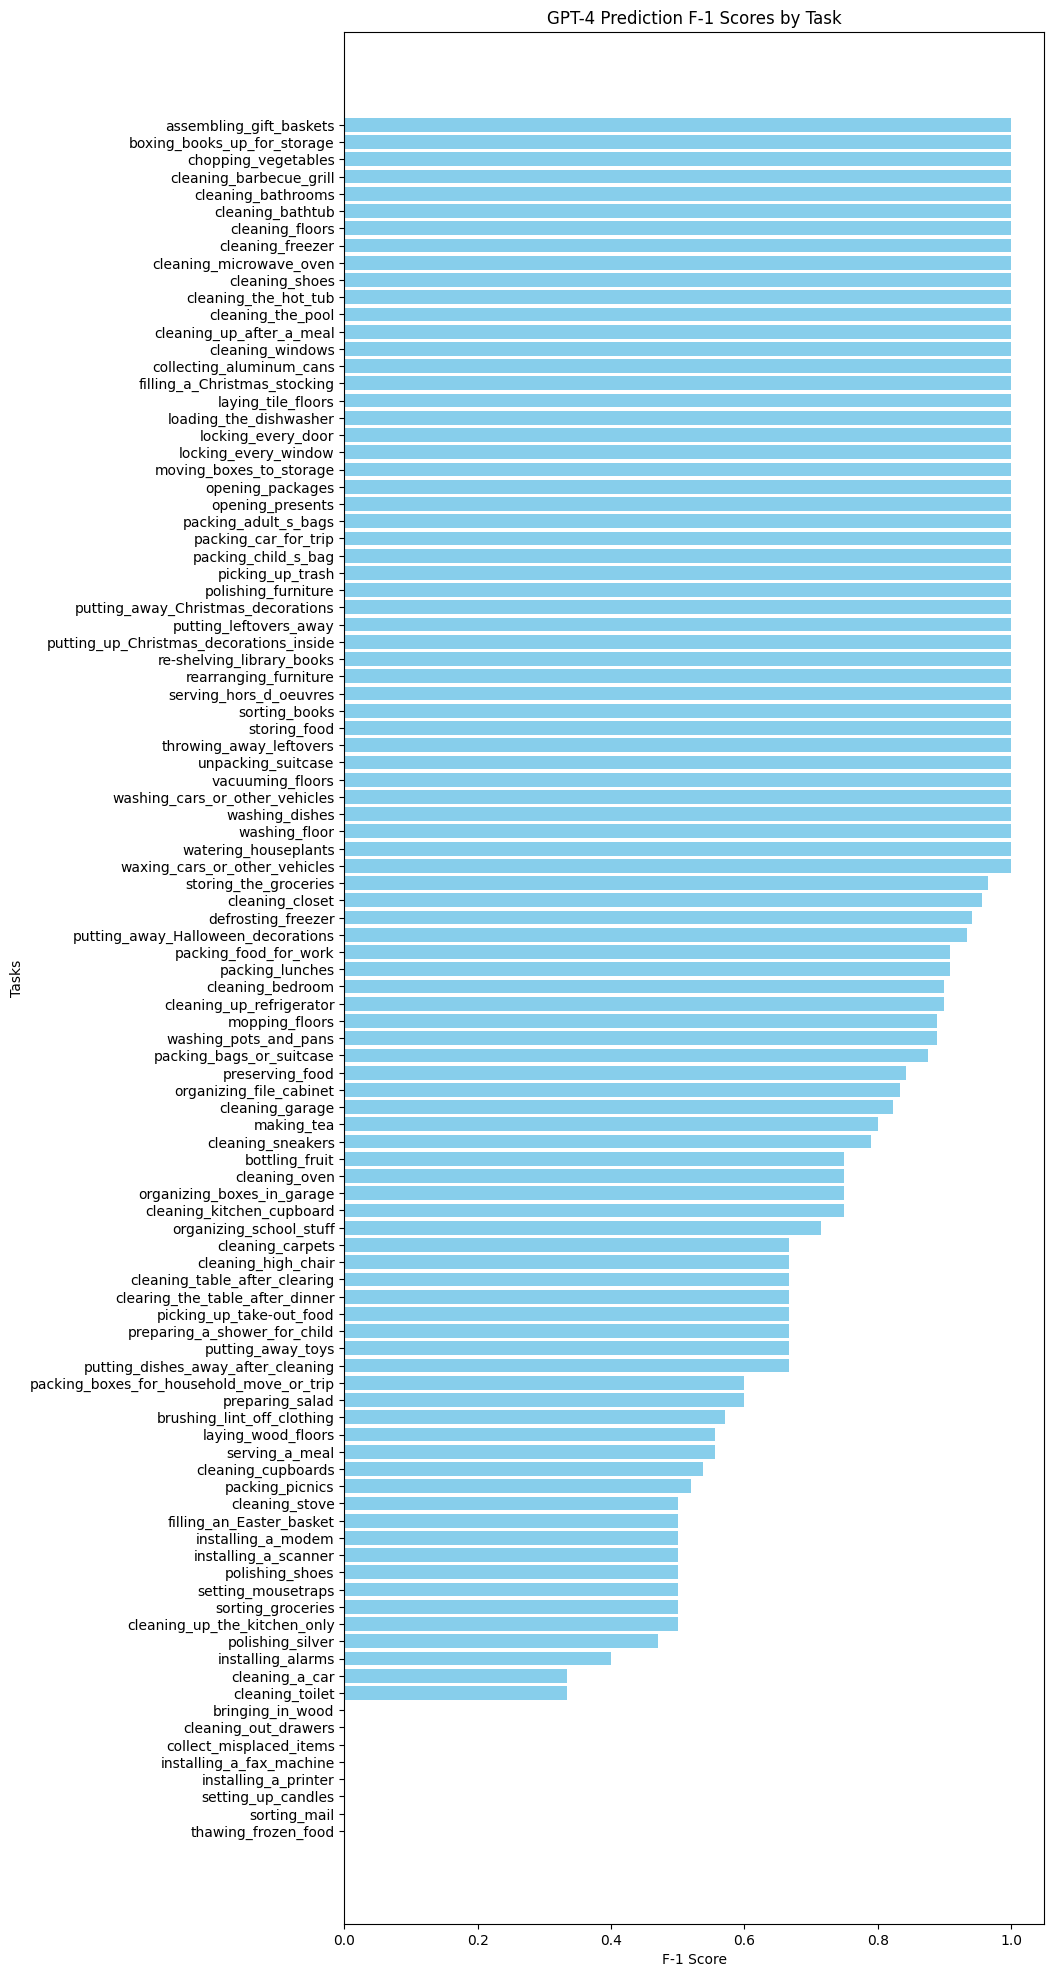

In [28]:
import matplotlib.pyplot as plt

# Sort the tasks first by descending F-1 score, then alphabetically by task name
sorted_tasks = sorted(f1_scores.items(), key=lambda x: (-x[1], x[0]))

# Unpack the sorted items for plotting
tasks, scores = zip(*sorted_tasks)

# Creating the horizontal bar graph
plt.figure(figsize=(10, 15))  # Adjusted for a vertical layout
plt.barh(tasks, scores, color='skyblue')
plt.xlabel('F-1 Score')
plt.ylabel('Tasks')
plt.title('GPT-4 Prediction F-1 Scores by Task')
plt.gca().invert_yaxis()  # Inverts the y-axis so high scores are at the top
plt.tight_layout()  # Adjusts subplots to give some padding
plt.subplots_adjust(left=0.2, right=0.9, top=1.3)  # Adjust the margins

# Save the plot to a file
plt.savefig('/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/images/GPT4_F1_Scores.png', format='png', dpi=400, bbox_inches='tight')  # Saves the plot as a PNG file with high resolution

plt.show()


In [35]:
f1_scores = {}
precisions = {}
recall = {}
accuracy = {}

for task_name, demo_name in task_to_demos.items():
    goal_conds = demo_to_conds[demo_name]['goal_conditions']
    gpt35_pred = gpt35_results[demo_name]
    gpt35_result = evaluate_goals(gpt35_pred, goal_conds)
    # gpt4_pred = gpt4_results[demo_name]
    # gpt4_result = evaluate_goals(gpt4_pred, goal_conds)
    f1_scores[task_name] = gpt35_result['f1_score']
    precisions[task_name] = gpt35_result['precision']
    recall[task_name] = gpt35_result['recall']
    accuracy[task_name] = gpt35_result['accuracy']


precisions["cleaning_up_after_a_meal"] = 1.0

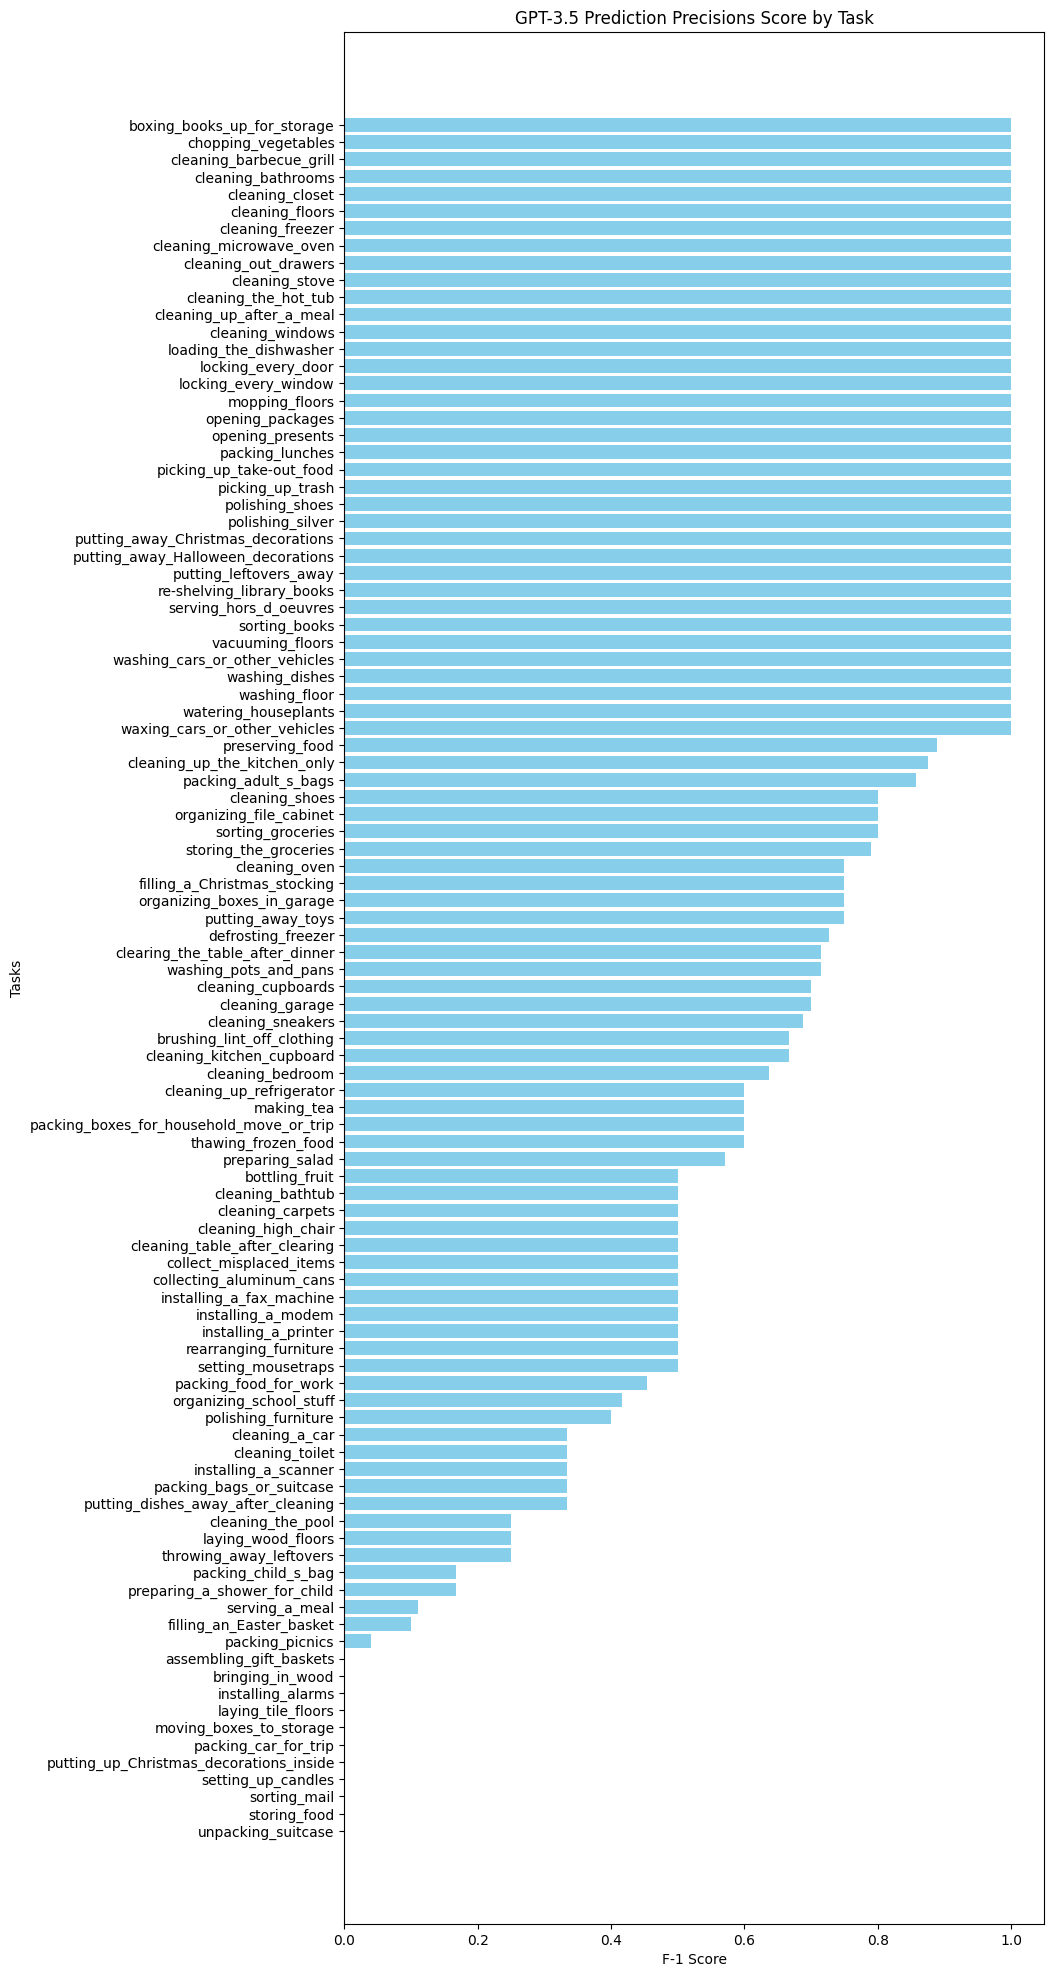

In [36]:
# Sort the tasks first by descending F-1 score, then alphabetically by task name
sorted_tasks = sorted(precisions.items(), key=lambda x: (-x[1], x[0]))

# Unpack the sorted items for plotting
tasks, scores = zip(*sorted_tasks)

# Creating the horizontal bar graph
plt.figure(figsize=(10, 15))  # Adjusted for a vertical layout
plt.barh(tasks, scores, color='skyblue')
plt.xlabel('F-1 Score')
plt.ylabel('Tasks')
plt.title('GPT-3.5 Prediction Precisions Score by Task')
plt.gca().invert_yaxis()  # Inverts the y-axis so high scores are at the top
plt.tight_layout()  # Adjusts subplots to give some padding
plt.subplots_adjust(left=0.2, right=0.9, top=1.3)  # Adjust the margins

# Save the plot to a file
plt.savefig('/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/images/GPT35_Precision_Scores.png', format='png', dpi=400, bbox_inches='tight')  # Saves the plot as a PNG file with high resolution

plt.show()

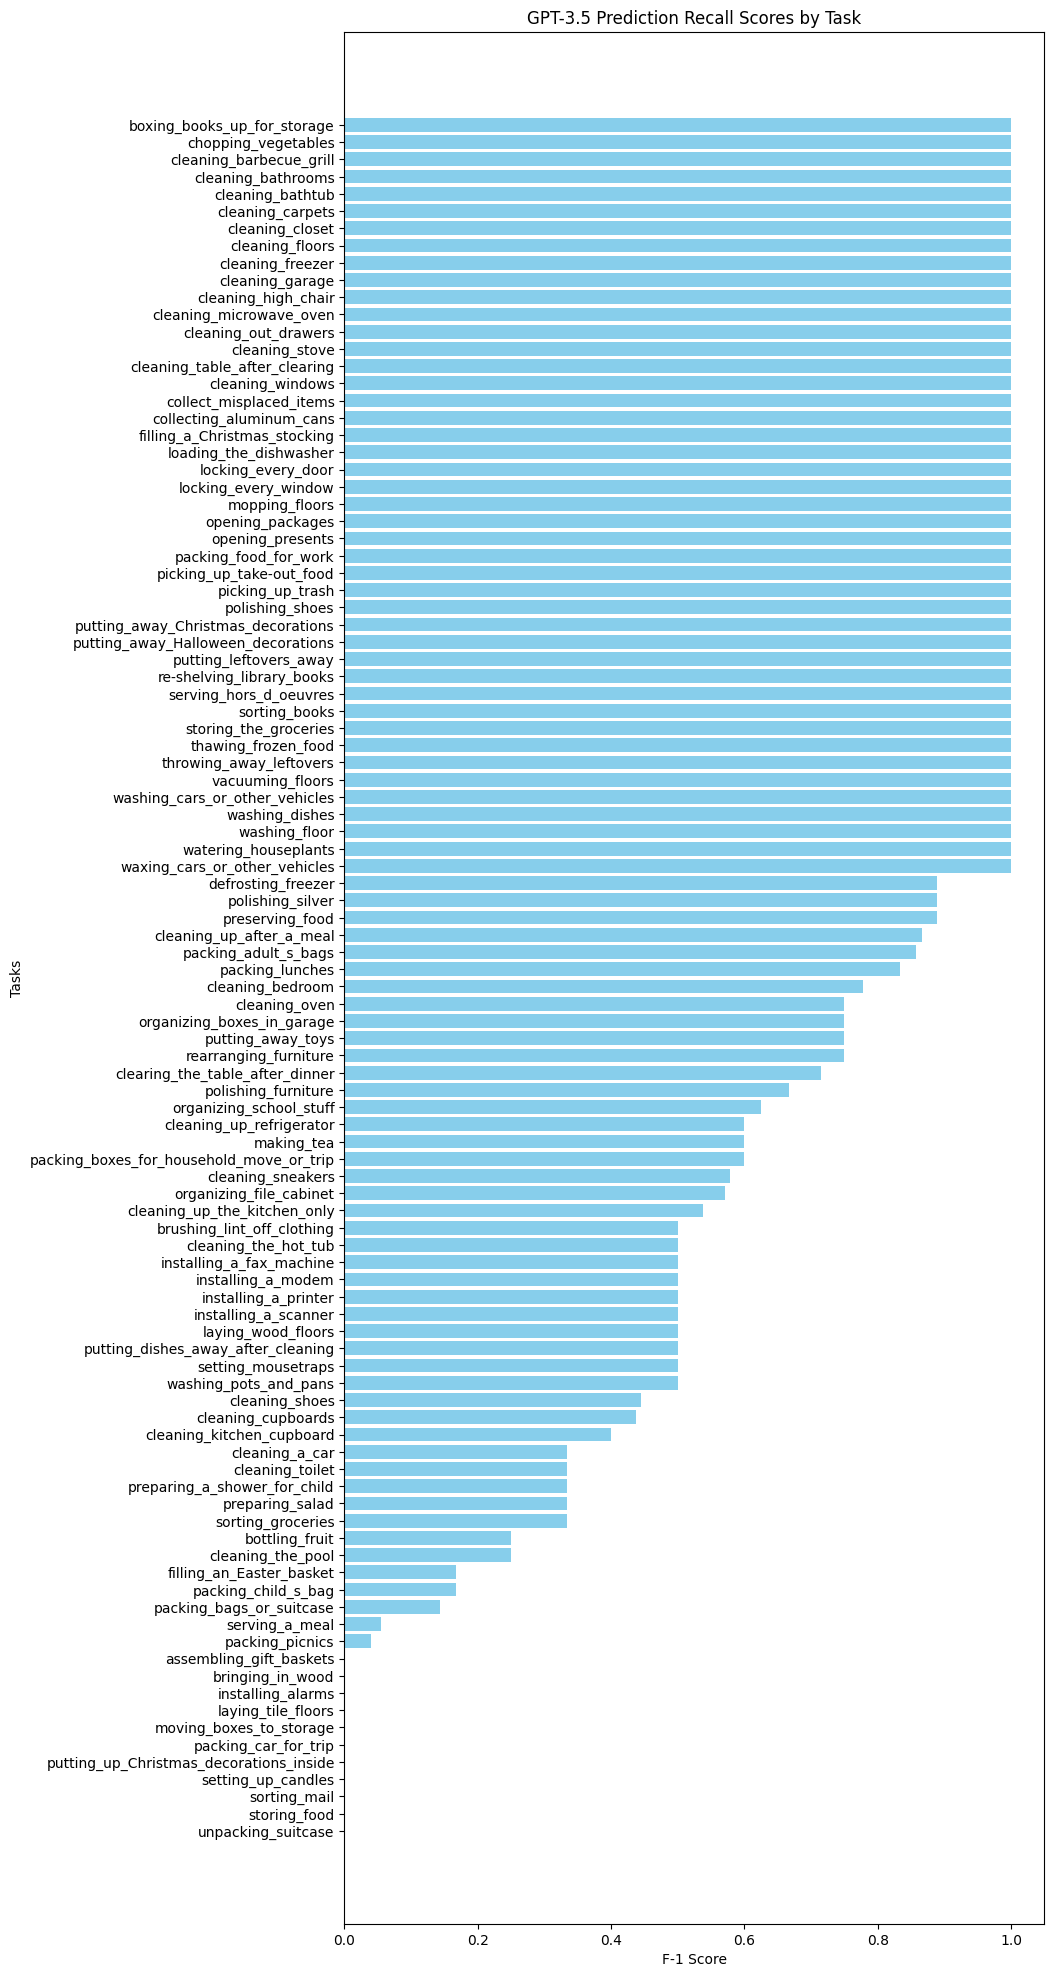

In [33]:
# Sort the tasks first by descending F-1 score, then alphabetically by task name
sorted_tasks = sorted(recall.items(), key=lambda x: (-x[1], x[0]))

# Unpack the sorted items for plotting
tasks, scores = zip(*sorted_tasks)

# Creating the horizontal bar graph
plt.figure(figsize=(10, 15))  # Adjusted for a vertical layout
plt.barh(tasks, scores, color='skyblue')
plt.xlabel('F-1 Score')
plt.ylabel('Tasks')
plt.title('GPT-3.5 Prediction Recall Scores by Task')
plt.gca().invert_yaxis()  # Inverts the y-axis so high scores are at the top
plt.tight_layout()  # Adjusts subplots to give some padding
plt.subplots_adjust(left=0.2, right=0.9, top=1.3)  # Adjust the margins

# Save the plot to a file
plt.savefig('/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/images/GPT3.5_Recall_Scores.png', format='png', dpi=400, bbox_inches='tight')  # Saves the plot as a PNG file with high resolution

plt.show()

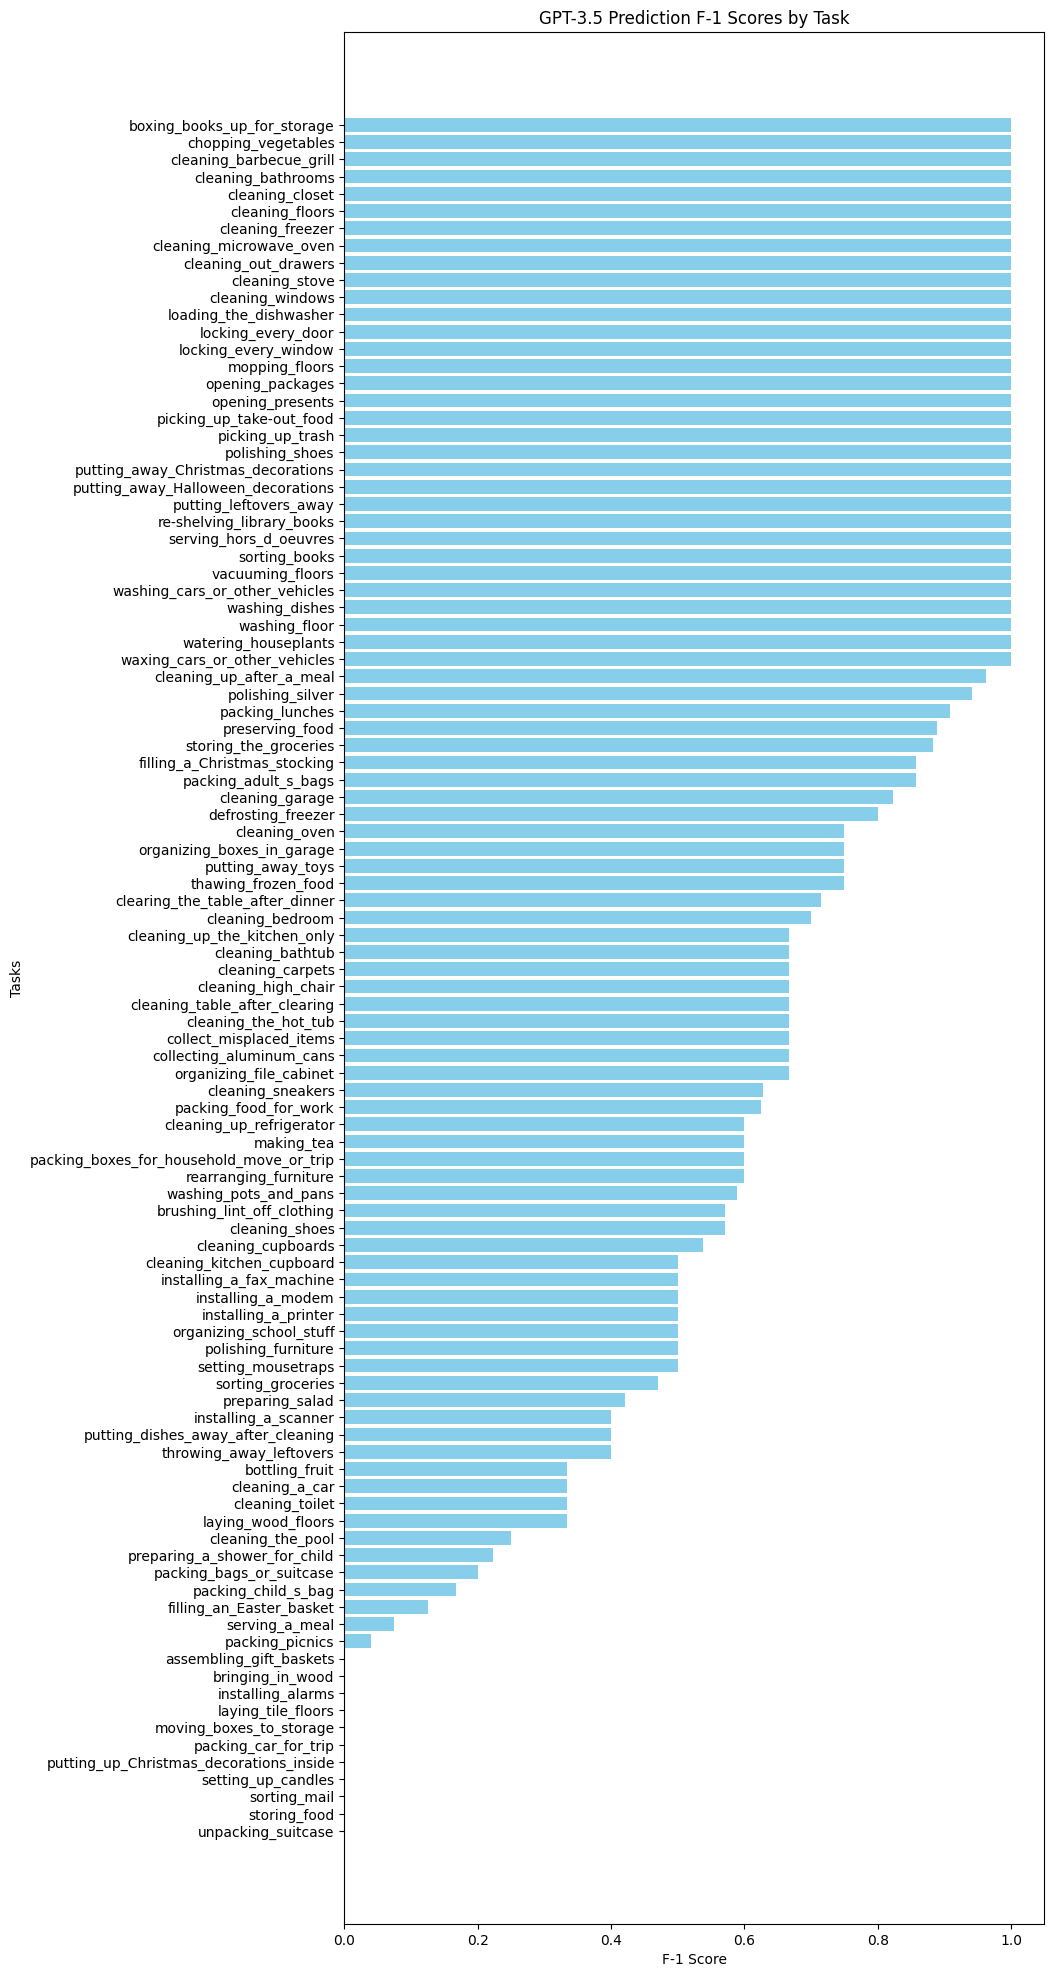

In [34]:
import matplotlib.pyplot as plt

# Sort the tasks first by descending F-1 score, then alphabetically by task name
sorted_tasks = sorted(f1_scores.items(), key=lambda x: (-x[1], x[0]))

# Unpack the sorted items for plotting
tasks, scores = zip(*sorted_tasks)

# Creating the horizontal bar graph
plt.figure(figsize=(10, 15))  # Adjusted for a vertical layout
plt.barh(tasks, scores, color='skyblue')
plt.xlabel('F-1 Score')
plt.ylabel('Tasks')
plt.title('GPT-3.5 Prediction F-1 Scores by Task')
plt.gca().invert_yaxis()  # Inverts the y-axis so high scores are at the top
plt.tight_layout()  # Adjusts subplots to give some padding
plt.subplots_adjust(left=0.2, right=0.9, top=1.3)  # Adjust the margins

# Save the plot to a file
plt.savefig('/Users/bryan/Desktop/wkdir/behavior-vllm-eval/igibson/evaluation/goal_interpretation/images/GPT35_F1_Scores.png', format='png', dpi=400, bbox_inches='tight')  # Saves the plot as a PNG file with high resolution

plt.show()